In [11]:
import numpy as np
from numpy import sin, cos
import time
import matplotlib.pyplot as plt
# import seaborn as sns
# sns.set_theme('whitegrid')
from matplotlib.patches import Rectangle
import scipy.integrate as integrate
import matplotlib.animation as animation
from collections import deque
from scipy.integrate import solve_ivp
from tqdm.notebook import tqdm

import torch
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

import config
from config import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1.1. Vehicle Specifications
* `m1`: car's body mass (kg)
* `m2`: car's wheel mass (kg)
* `cs`: controllable scalar of ??; in range [1000, 2000]
* `ks`: spring stiffness (N/m)
* `kw`: wheel stiffness  (N/m)

In [12]:
%autoreload 2

m1= config.m1
m2= config.m2
m = [m1,m2]
cs = config.cs
ks= config.ks
kw= config.kw

### 1.2. Road Model

In [13]:
import random

"""======================================
    SIMULATE ROAD PROFILES
======================================"""
def generate_road(TIME, MAX_BUMP, mode='hump'):
    """ Create array of road profile"""
    road_profile = [t for t in range(len(TIME))]
    for t_idx, t in enumerate(TIME):
        # road_profile[t_idx]= random.uniform(-0.005, 0.005) # No roughness by default
        road_profile[t_idx] = 0.0

        """ Model Speed bumps"""
        if mode == 'hump':
            if t >= 1 and t <= 1.5:
                # road_profile[t_idx]=MAX_BUMP
                t0 = t-1
                road_profile[t_idx]= -(16*MAX_BUMP) * (t0)**2 + 8*MAX_BUMP * (t0)
            # if t >= 2 and t <= 2.5:
            #     # road_profile[t_idx]=MAX_BUMP
            #     t0 = t-2
            #     road_profile[t_idx]= -(16*MAX_BUMP) * (t0)**2 + 8*MAX_BUMP * (t0)
            # if t >= 3 and t <= 3.5:
            #     # road_profile[t_idx]=MAX_BUMP
            #     t0 = t-3
            #     road_profile[t_idx]= -(16*MAX_BUMP) * (t0)**2 + 8*MAX_BUMP * (t0)
            # if t >= 4 and t <= 4.5:
            #     # road_profile[t_idx]=MAX_BUMP
            #     t0 = t-4
            #     road_profile[t_idx]= -(16*MAX_BUMP) * (t0)**2 + 8*MAX_BUMP * (t0)
            # if t >= 5 and t <= 5.5:
            #     # road_profile[t_idx]=MAX_BUMP
            #     t0 = t-5
            #     road_profile[t_idx]= -(16*MAX_BUMP) * (t0)**2 + 8*MAX_BUMP * (t0)
            # if t >= 2 and t <= 2.2:
            #     road_profile[t_idx]=MAX_BUMP
            # elif t >= 3 and t <= 3.2:
            #     road_profile[t_idx]=MAX_BUMP
            # elif t >= 4 and t <= 4.2:
            #     road_profile[t_idx]=MAX_BUMP
            # elif t >= 23 and t <= 23.2:
            #     road_profile[t_idx]=MAX_BUMP

            # """ Model trough"""
            # if t >= 6 and t <= 6.2:
            #     road_profile[t_idx]=-MAX_BUMP
        elif mode == 'rectangular':
            if t >= 1 and t <= 5:
                road_profile[t_idx] = 1.5

    return road_profile

In [14]:
"""======================================
    ISO Road Profile Generator
======================================"""
class RoadProfile(object):

    '''
    Based on method described in:
        Da Silva, J. G. S. "Dynamical performance of highway bridge
        decks with irregular pavement surface."
        Computers & structures 82.11 (2004): 871-881.

    Attributes:
        Gdn0 (float): Gd(n0)
        n0 (float): reference spatial frequency
        n_max (float): max spatial frequency
        n_min (float): min spatial frequency
        w (int): set according to the value in page 14 of ISO
    '''

    n_min = 0.0078  # min spatial frequency
    n_max = 40.  # max spatial frequency
    n0 = 0.1  # reference spatial frequency
    w = 2  # set according to the value in page 14 of ISO
    iso_Gdn0 = {"A": 32E-6,
                "B": 128E-6,
                "C": 512E-6,
                "D": 2048E-6,
                "E": 8192E-6,
                "F": 32768E-6}

    def __init__(self, Gdn0=32E-6):
        '''Gdn0, displacement power spectral density (m**3)

        Args:
            Gdn0 (float, optional): Gd(n0)
        '''
        self.Gdn0 = Gdn0

    def generate(self, L=100., dx=0.1, center = False):
        """Summary

        Args:
            L (float, optional): Length of the road profile
            dx (float, optional): Interval between two points
            center (bool, optional): Center the profile mean to zero

        Returns:
            array : Road profile
        """
        x = np.arange(0, L+dx/2., dx)
        components = int(L/dx/2)
        ns = np.linspace(self.n_min, self.n_max, components)

        Gd = np.sqrt(self.Gdn0 * (ns/self.n0)**(-self.w) *
                     2*(self.n_max - self.n_min)/components)

        profile = np.zeros(np.size(x))
        phase = np.random.rand(components)*2*np.pi
        for i in range(len(x)):
            profile[i] = np.sum(Gd*np.cos(2*np.pi*ns*x[i]-phase))

        if center:
            profile -= np.mean(profile)

        return [x,profile]

    def set_profile_class(self, profile_class="A"):
        """Summary

        Args:
            profile_class (str, optional): A-F
        """
        try:
            self.Gdn0 = self.iso_Gdn0[profile_class.upper()]
        except:
            raise ValueError("Profile name is not predefined.")

    def get_profile_by_class(self, profile_class="A", L=100, dx=0.1, center = False):
        """Summary

        Args:
            profile_class (str, optional): A-F
            L (int, optional): Length of the road profile
            dx (float, optional): Interval between two points
            center (bool, optional): Center the profile mean to zero

        Returns:
            array: Road profile

        """
        try:
            self.Gdn0 = self.iso_Gdn0[profile_class.upper()]
            return self.generate(L, dx)
        except:
            raise ValueError("Profile name is not predefined.")

### Generate Road Profile

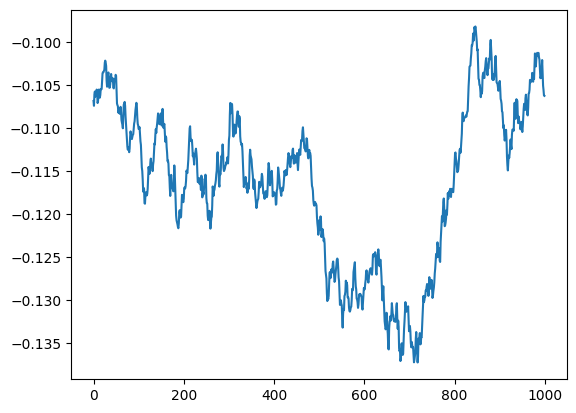

In [15]:
%autoreload 2

# road_profile = generate_road(TIME, MAX_BUMP)

testprofile = RoadProfile()
road_profile = list(testprofile.get_profile_by_class("C", t_stop, dt)[1][1:])

plt.plot(road_profile)
# print(road_profile[1])

### 2. ODE of Quarter Car model

In [16]:
"""
    Initial state of the environment.
    System of 4 variables to be solved:
        y0[0] = x_body; (x1)
        y0[1] = x_wheel; (x2)
        y0[2] = d(x_body)/dt; (dx1/dt)
        y0[3] = d(x_wheel)/dt; (dx2/dt)
"""
y0 = [road_profile[0], road_profile[0], 0, 0]
history_len = 600  # how many trajectory points to display
r=0
offset1=0.3 #The offset used by the wheel equilibrium equations [m]
offset2=0.5 #The offset used by the wheel equilibrium equations [m]
L=0.5
H=0.2

In [17]:
"""
    ODE of Quarter Car model
    :t  - timesteps
    :y0 - initial state [xb, xw, d/dt(xb), d/dt(xw)]
    :m  - tuple containing (m_body, m_wheel)
    :cs - constant related to ...
    :ks - spring stiffness
    :kw - tire stiffness

    :return [d/dt(xb), d/dt(xw), d2/dt(xb), d2/dt(xw)]
"""
def odefun(t, y0, m, cs, kw, ks):
    m1=m[0];    # Body mass in kg
    m2=m[1];    # Wheel mass in kg

    """ Road condition at time step t"""
    t_idx = min(round(t/dt), len(TIME)-1)
    xr = road_profile[t_idx]
    # print(t)

    """ 1. Displacement & Velocity of body & wheel """
    xb = y0[0]                # x_body        (x1)
    xw = y0[1]                # x_wheel       (x2)
    dxb = y0[2]               # d(x_body)/dt  (dx1/dt)
    dxw = y0[3]               # d(x_wheel)/dt (dx2/dt)
    """ 2. Acceleration of body & wheel """
    d2xb = - ks/m1*(xb-xw) - cs/m1*(dxb-dxw)  # + kw/m1*xr - kw/m1*xb
    d2xw = ks/m2*(xb-xw) + cs/m2*(dxb-dxw) + kw/m2*(xr-xw)

    return [dxb,dxw,d2xb,d2xw]

### 2.1. Visualization for Physical Consistency
We have 2 targets and need to minimize 2 quanitities
* Minimize `xb`: minimize the body displacement for more confort ride
* Minimize `dxb`: minimize the body velocity to avoid sudden impact to the riders

### * Reproduce the Solution with time-step-wise (dt-wise) solutions

0it [00:00, ?it/s]

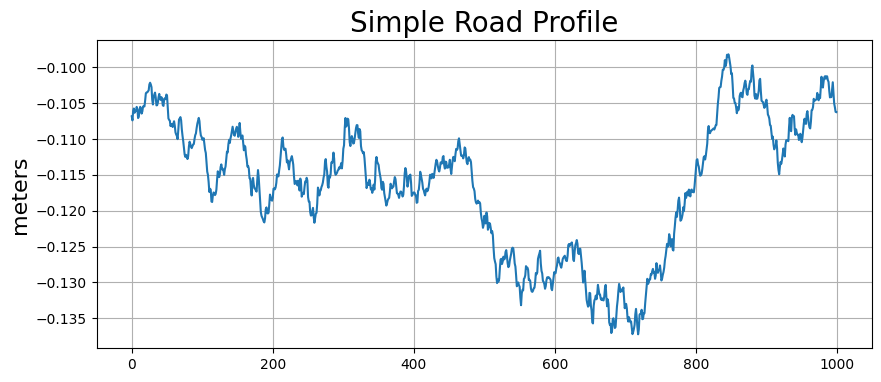

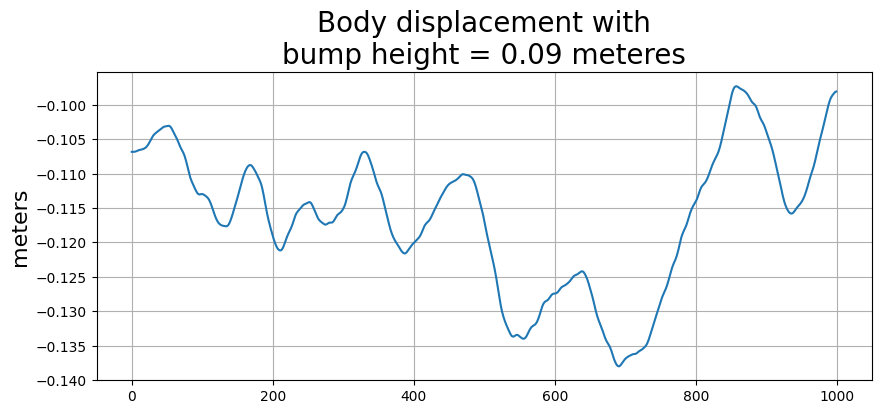

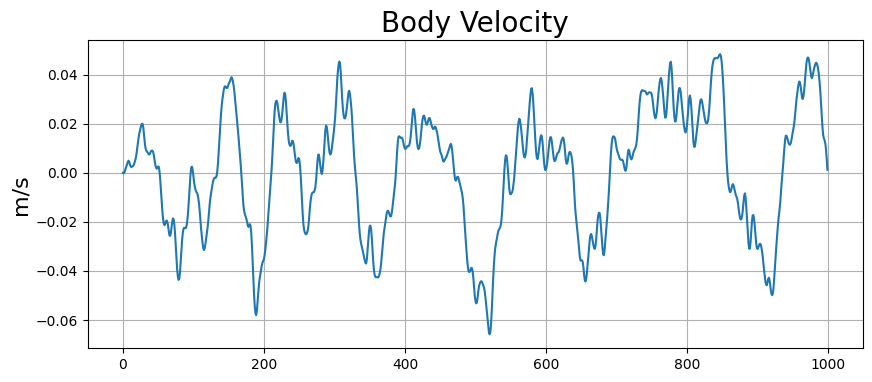

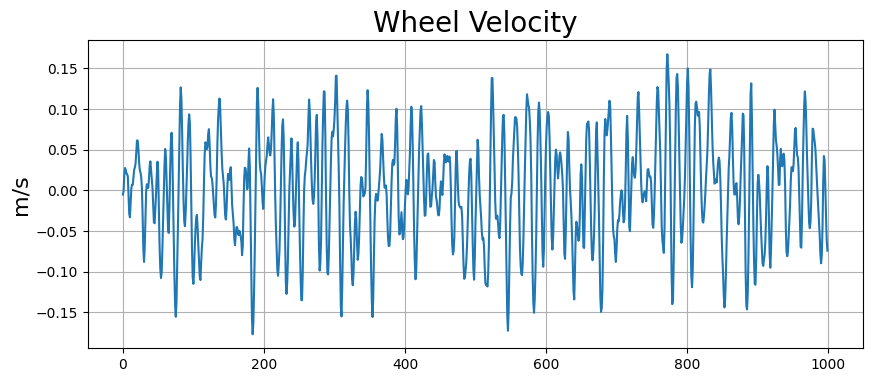

In [18]:
xb_time = []
dxb_time = []
xw_time = []
dxw_time = []

st = [road_profile[0], road_profile[0], 0, 0]

""" Visualization"""
# fig, ax = plt.subplots(ncols=3, figsize=(60,5))
plt.figure(figsize=(10,4))
plt.title(f'Simple Road Profile', fontsize=20)
plt.plot(road_profile)
plt.ylabel('meters', fontsize=16)
# plt.ylim([-0.5, 1])
plt.grid()

for t_idx, t in tqdm(enumerate(TIME)):
    """ Solve ODE for the next states """
    yout = solve_ivp(odefun, [t, t+dt], st, args=(m, cs, kw, ks ), dense_output=True)
    xb = yout.y[0,-1] #.mean()
    xw = yout.y[1,-1] #.mean()
    dxb = yout.y[2,-1] #.mean()
    dxw = yout.y[3,-1] #.mean()

    # print(yout.sol(TIME[t_idx : t_idx+1])[:,0])

    """ Record the state history"""
    xb_time.append(xb)
    dxb_time.append(dxb)
    xw_time.append(xw)
    dxw_time.append(dxw)

    """ Transition to new state"""
    st = [xb, xw, dxb, dxw]

plt.figure(figsize=(10,4))
plt.title(f'Body displacement with\nbump height = {MAX_BUMP} meteres', fontsize=20)
plt.plot(xb_time)
plt.ylabel('meters', fontsize=16)
# plt.ylim([-2*MAX_BUMP, 2*MAX_BUMP])
plt.grid()

plt.figure(figsize=(10,4))
plt.title(f'Body Velocity', fontsize=20)
plt.plot(dxb_time)
plt.ylabel('m/s', fontsize=16)
# ax[2].set_ylim([-1*MAX_BUMP, 1.5*MAX_BUMP])
plt.grid()
plt.show()

plt.figure(figsize=(10,4))
plt.title(f'Wheel Velocity', fontsize=20)
plt.plot(dxw_time)
plt.ylabel('m/s', fontsize=16)
# ax[2].set_ylim([-1*MAX_BUMP, 1.5*MAX_BUMP])
plt.grid()
plt.show()

### 3. Reinforcement Learning Framework
* input state $s_t$   = $[x_b, x_w, \dot{x_b}, \dot{x_w}] \in R^4$
* output action $a_t$ = $c_s \in R$

* Models:
    1. $Q_{target}$: delayed-update QNetwork
    2. $Q_{origin}$: QNetwork
    3. $\mu_{target}$: delayed-updated Policy Network
    4. $\mu_{origin}$: Policy Network

* Delayed Soft Update:
    1. $Q_{target} = \tau Q_{target} + (1-\tau)Q_{origin}$
    2. $\mu_{target} = \tau \mu_{target} + (1-\tau)\mu_{origin}$

In [51]:
import random
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
from config import *

#### 3a. Model definition

In [52]:
%autoreload 2
"""
    Q-Network: CRITIC
        function: (st,at) -> Q-value = Q(st, at)
"""
class QNet(nn.Module):
    def __init__(self, input_dim=4+2, hidden_dim=64, output_dim=1):
        super().__init__()
        self.hidden1 = nn.Linear(input_dim, hidden_dim)
        self.hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)

    def forward(self, s, a):
        outs = torch.cat([s, a], dim=-1)
        outs = F.relu(self.hidden1(outs))
        outs = F.relu(self.hidden2(outs))
        outs = self.output(outs)
        # outs = 1000*outs
        return outs

"""
    Policy Network: ACTOR
        function:  st -> at
"""
class PolicyNet(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=64, output_dim=1):
        super().__init__()
        self.hidden1 = nn.Linear(input_dim, hidden_dim)
        self.hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)

    def forward(self, s):
        outs = F.relu(self.hidden1(s))
        outs = F.relu(self.hidden2(outs))
        outs = self.output(outs)
        outs = torch.tanh(outs)    # range [-1, 1]
        # outs = outs * 500   # desire output is [1000,2000]
        return outs

In [53]:
%autoreload 2
""" 1. Initialize Critics (Q-Networks)
        Q_origin: instantly updated weights
        Q_target: delayed weights (updated periodically)
            * NOTE: Q_target are not back-propagated -> disable require_grads for efficiency
    --> "Twin-delayed" to increase training stability & convergence
"""
Q_origin = QNet(input_dim+output_dim, Q_hidden_dim, 1).to(device)
Q_target = QNet(input_dim+output_dim, Q_hidden_dim, 1).to(device)
Q_target.requires_grad_(False)

""" 2. Initialize Actors (Policy Networks)
        Q_origin: instantly updated weights
        Q_target: delayed weights (updated periodically)
            * NOTE: Q_target are not back-propagated -> disable require_grads for efficiency
    --> "Twin-delayed" to increase training stability & convergence
"""
mu_origin = PolicyNet(input_dim, mu_hidden_dim, output_dim).to(device)
mu_target = PolicyNet(input_dim, mu_hidden_dim, output_dim).to(device)
mu_target.requires_grad_(False)

print(lr)
print(device)
Q_origin = Q_origin.to(device)
mu_origin = mu_origin.to(device)
print(Q_origin)
print(mu_origin)

0.001
cpu
QNet(
  (hidden1): Linear(in_features=8, out_features=32, bias=True)
  (hidden2): Linear(in_features=32, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=1, bias=True)
)
PolicyNet(
  (hidden1): Linear(in_features=6, out_features=16, bias=True)
  (hidden2): Linear(in_features=16, out_features=16, bias=True)
  (output): Linear(in_features=16, out_features=2, bias=True)
)


#### 3b. Optimizer Framework

In [54]:
optimizer_Qnet = torch.optim.Adam(Q_origin.parameters(), lr=lr)
optimizer_munet = torch.optim.Adam(mu_origin.parameters(), lr=lr/10)

"""**********************************************************
    Optimization framework for Twin-Delayed (TD) Critic & Actor
    :states      - st
    :actions     - at
    :rewards     - rt
    :next_states - s{t+1}
    :dones       - bool

    Purpose:
        * Update weights of Q_orig and mu_orig using back-propagation
        * Q_target & mu_target are NOT updated (soft delayed updated separately)
**********************************************************"""
def optimize(states, actions, rewards, next_states, dones):
    """ 1. Tensor conversion of (st, at, rt, s{t+1}, done)"""
    states = torch.tensor(states, dtype=torch.float).to(device)
    actions = torch.tensor(actions, dtype=torch.float).to(device)
    # actions = actions.unsqueeze(dim=1)
    rewards = torch.tensor(rewards, dtype=torch.float).to(device)
    rewards = rewards.unsqueeze(dim=1)
    next_states = torch.tensor(next_states, dtype=torch.float).to(device)
    dones = torch.tensor(dones, dtype=torch.float).to(device)
    dones = dones.unsqueeze(dim=1)

    # print('States:', states.shape, ', Actions:', actions.shape, \
    #       ', Rewards:', rewards.shape, ', Next States:', next_states.shape)

    """ 2. Critic Loss Optimization"""
    optimizer_Qnet.zero_grad()
    qvals = Q_origin(states, actions)                            # Q_orig(st, at)
    a_next_tgt = mu_target(next_states)                          # a{t+1}_tgt
    qvals_next_tgt = Q_target(next_states, a_next_tgt)           # Q_tgt(s{t+1}, a{t+1}_tgt)
    qvals_tgt = rewards + (1.0 - dones) * gamma * qvals_next_tgt # Q_tgt(st, at) = rt + gamma*Q_tgt(s{t+1}, a{t+1})

    """ 2.1. Update Critic -> Minimize MSE between
            `Q_orig(st, at)` and `rt + gamma*Q_tgt(s{t+1}, a{t+1})`
                where:
                    Q_orig, Q_tgt    is given
                    mu_orig, mu_tgt  is given
                    st, at, rt, s{t+1} is given
                    a{t+1} = mu_tgt(s{t+1})
    """
    loss_Q = F.mse_loss(qvals, qvals_tgt, reduction="none")
    loss_Q.sum().backward()
    optimizer_Qnet.step()


    """ 3. Actor Loss Optimization"""
    """ 3.1. Freeze Critic (Q_origin) before Actor (mu_origin) optimization"""
    for p in Q_origin.parameters():
        p.requires_grad = False

    """ 3.2. Update Actor -> Maximize the reward"""
    optimizer_munet.zero_grad()
    a_next = mu_origin(states)            # a{t+1} = mu_orig(s{t})
    q_tgt_max = Q_origin(states, a_next)  #
    (-q_tgt_max).sum().backward()          # (q_tgt_max) or (-q_tgt_max) ?
    optimizer_munet.step()

    """ 3.1. Unfreeze Critic (Q_origin) """
    for p in Q_origin.parameters():
        p.requires_grad = True # enable grad again

"""**********************************************************
    Soft-update Delayed Target models:
        Q_target = tau*Q_target + (1-tau)*Q_orig
        mu_target = tau*mu_target + (1-tau)*mu_orig
**********************************************************"""
def update_target():
    for var, var_target in zip(Q_origin.parameters(), Q_target.parameters()):
        var_target.data = tau * var_target.data + (1.0 - tau) * var.data
    for var, var_target in zip(mu_origin.parameters(), mu_target.parameters()):
        var_target.data = tau * var_target.data + (1.0 - tau) * var.data

"""
    Use replay buffer to enrich past experience
    ->  avoid biased toward recent experience
        (hence forgot past interactions / rare situations)
"""
class replayBuffer:
    def __init__(self, buffer_size: int):
        self.buffer_size = buffer_size
        self.buffer = []
        self._next_idx = 0

    def add(self, item):
        if len(self.buffer) > self._next_idx:
            self.buffer[self._next_idx] = item
        else:
            self.buffer.append(item)
        if self._next_idx == self.buffer_size - 1:
            self._next_idx = 0
        else:
            self._next_idx = self._next_idx + 1

    def sample(self, batch_size):
        indices = [random.randint(0, len(self.buffer) - 1) for _ in range(batch_size)]
        states   = [self.buffer[i][0] for i in indices]
        actions  = [self.buffer[i][1] for i in indices]
        rewards  = [self.buffer[i][2] for i in indices]
        n_states = [self.buffer[i][3] for i in indices]
        dones    = [self.buffer[i][4] for i in indices]
        return states, actions, rewards, n_states, dones

    def length(self):
        return len(self.buffer)

"""**********************************************************
    Ornstein-Uhlenbeck noise implemented by OpenAI
    Copied from https://github.com/openai/baselines/blob/master/baselines/ddpg/noise.py
**********************************************************"""
class OrnsteinUhlenbeckActionNoise:
    def __init__(self, mu, sigma, theta=.15, dt=1e-2, x0=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.reset()

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

# pick up action with Ornstein-Uhlenbeck noise
def pick_sample(s, ou_action_noise):
    with torch.no_grad():
        s = np.array(s)
        s_batch = np.expand_dims(s, axis=0)
        s_batch = torch.tensor(s_batch, dtype=torch.float).to(device)
        action_det = mu_origin(s_batch)
        action_det = action_det.squeeze(dim=1)
        noise = ou_action_noise()
        action = action_det.cpu().numpy() + noise
        # action = np.clip(action, -1.0, 1.0)
        # return float(action.item())
        return action.astype(float)[0]

### 3c. Training pipeline
In each episode:
   1. Initialize `xb, xw, dxb, dxw` to be `[0, 0, 0, 0]`.
   2. For each state-action `(st, at)`, get next state `s{t+1}` using the ***ODE of Quarter Car Model***.
   3. For `(st, at)`, get `rt = -k1*|xb| - k2*(dxb)^2`.
       * We need to consider both displacement `xb` and velocity `dxb` for a comfort ride.
       * NOTE: change `k1` and `k2` appropriately for an unbiased priority between `xb` and `dxb`.
       
NOTE:
1. Modify `reward`: make the difference between rewards more significant -> ```exponent normalization```<br>
    - e.g: R1 = 0.1, R2 = 0.2 -> R1 = 0.1, R2 = 4 => 40 times more difference
        
2. Solve for $\ddot{x_b}$:
    * $m_b\ddot{x_b} = -k_s(x_b-x_w) - c_{sky}\dot{x_b}$ <br>
      where $c_{sky} = c_s(\dot{x_b}-\dot{x_w}) / \dot{x_b}$

In [56]:
"""
    Map Actor Network's output to real Cs action space
    Range: [-600, +600]
"""
def get_cs(a):
    return cs + 600*a

"""
    Map Actor Network's output to real Ks action space
    Range: [-4500, 4000]
"""
def get_ks(a):
    return ks + 4000*a if a > 0 else ks + 4500*a

# pick_sample(s_rl, ou_action_noise)
# print(s_rl, a)
# print(torch.cat([s_rl, a]), dim=-1)

In [57]:
""" Replay buffer """
# buffer = replayBuffer(buffer_size=1000000)
buffer = replayBuffer(buffer_size=100000)
""" Random Noise for Exploration (similar to epsilon exploration in discrete output problem) """
# ou_action_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(output_dim), sigma=np.ones(output_dim) * 0.2)

reward_records = []
best_score = -99999
rl_xb_time = [] # store series of body displacement here
rl_dxb_time = []
rl_cs = []
rl_ks = []

Q_origin.requires_grad_(True)
mu_origin.requires_grad_(True)
for i in tqdm(range(1000)):
    """ Randomly Generate new road profile each episode"""
    # road_profile = generate_road(TIME, MAX_BUMP)
    road_profile = list(testprofile.get_profile_by_class("E", t_stop, dt)[1][1:])

    """ Exploration factor """
    if i < 100:
        ou_action_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(output_dim), sigma=np.ones(output_dim) * 0.5)
    elif i < 200:
        ou_action_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(output_dim), sigma=np.ones(output_dim) * 0.1)
    else:
        ou_action_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(output_dim), sigma=np.ones(output_dim) * 0.05)
    """
        Initialize the first state of the quarter car model & RL model
         * state_ODE e R4: [x_body, x_wheel, d/dt(x_body), d/dt(x_wheel)]
         * state_RL  e R5: [d/dt(x_body), d/dt(x_wheel), d/dt(road_profile)]
    """
    s_ode = [road_profile[0], road_profile[0], 0, 0]  # [xb, xw, dxb, dxw] e R4 -> state representation of the quarter car model
    s_ode_prev = s_ode
    s_rl = None # [xb, xw, dxb, dxw, d2xb] e R5  -> state representation of the RL model
    done = False
    total_reward = 0
    temp_xb_time = []
    temp_dxb_time = []

    """ Episode optimization"""
    for t_idx, t in enumerate(TIME):
        """####################################
            I. S{t} & A{t} COMPUTATION
        ####################################"""
        """ 1.1. Get current state s{t} from ODE """
        xb, xw, dxb, dxw = np.array(s_ode)[0:4]
        dxr = (road_profile[t_idx] - road_profile[t_idx-1]) / dt
        xb_prev, xw_prev, dxb_prev, dxw_prev = np.array(s_ode_prev)[0:4]
        dxr_prev = (road_profile[max(t_idx-1, 0)] - road_profile[max(t_idx-2, 0)]) / dt
        # s_rl = [xb, xw, dxb, dxw, dxr] # rescale
        # s_rl = [dxb, dxw, dxr] # rescale
        s_rl = [dxb, dxw, dxr, dxb_prev, dxw_prev, dxr_prev] # rescale
        """ 1.2. Take action a{t} from RL's s{t}"""
        a = pick_sample(s_rl, ou_action_noise)
        a_cs, a_ks = a
        """ 1.3. Compute d2/dt (x_body)"""
        d2xb = (-get_cs(a_cs) * (dxb-dxw) - get_ks(a_ks) * (xb-xw)) / m1

        """ 1.4. Record curves"""
        temp_xb_time.append(xb)
        temp_dxb_time.append(dxb)
        rl_cs.append(get_cs(a_cs))
        rl_ks.append(get_ks(a_ks))


        """####################################
            II. S{t+1} TRANSITION (from S{t} & A{t})
        ####################################"""
        # s_next, r, done, _ = env.step(a)
        """ 2.1. Solve ODE for s{t+1} """
        # del xb, xw, dxb, dxw # delete these variables for debugging purpose
        yout = solve_ivp(odefun, [t, t+dt], s_ode, args=(m, get_cs(a_cs), kw, ks ), dense_output=True)
        # yout.y is the solution of the ODE -> s{t+1}
        xb_next, xw_next, dxb_next, dxw_next = yout.y[:,-1]
        if t_idx < len(TIME)-1:
            dxr_next = (road_profile[t_idx+1] - road_profile[t_idx]) / dt
        """ 2.2. Record next states"""
        s_ode_next = [xb_next, xw_next, dxb_next, dxw_next]
        # s_rl_next = [xb, xw, dxb, dxw, dxr]
        # s_rl_next = [dxb_next, dxw_next, dxr_next]
        s_rl_next = [dxb_next, dxw_next, dxr_next, dxb, dxw, dxr]
        """ 2.3. Check final state"""
        done = False if (t_idx < len(TIME)-1) else True

        # """ compute C_skyhook -> based on fixed cs & ks? """
        # if abs(dxb) > 0.01:
        #     c_sky = get_cs(a_cs) * (dxb-dxw) / dxb
        # else:
        #     c_sky = get_cs(a_cs)
        # """ derive d2/dt(x_body) """
        # d2xb = (-get_ks(a_ks)*(xb-xw) - c_sky*dxb) / m1


        """####################################
            III. REWARDS, BUFFER, & MODEL UPDATES
        ####################################"""
        """ 3.1. Reward function"""
        # r = -0.7*abs(xb) - 0.3*(dxb)**2
        # r = -0.9*abs(xb) - 0.1*abs(dxb) # - abs(xb-xw)
        #  r = -0.1*abs(dxb) # -> TRAINED 1 USING THIS (with buffer size 1M)
        r = -1/10*abs(dxb_next) # -> TRAINED 2 USING THIS (with buffer size 100K)
        # r = -1/10*abs(xb) - 0.25e2*(abs(xb)**3)
        # r = -10*abs(d2xb)
        # r = -0.25e2*(abs(xb)**3)
        # r = -1000*(abs(xb)**3)
        # r = -1*(0.01*(abs(d2xb)**2))
        # r = (-1/10*(abs(xb))) - (0.001*(abs(d2xb)**2))
        # print(r)

        total_reward += r

        """ 3.2. buffer experience"""
        buffer.add([s_rl, a, r, s_rl_next, float(done)])

        """ 3.3. Update model based on buffered experience (st, at, rt, s{t+1}, done) """
        if buffer.length() >= bs:
            states, actions, rewards, n_states, dones = buffer.sample(bs)
            optimize(states, actions, rewards, n_states, dones)
            update_target()

        """####################################
            IV. STATE TRANSITION
        ####################################"""
        s_ode_prev = s_ode
        s_ode = s_ode_next

    # Output total rewards in episode (max 500)
    print(f"Run episode {i} with rewards {total_reward}")
    reward_records.append(total_reward)

    if best_score < total_reward:
        best_score = total_reward
        print(f'New best score: {best_score}')
        rl_xb_time = temp_xb_time
        rl_dxb_time = temp_dxb_time

        torch.save(Q_origin, './Q_origin_random_2.pt')
        torch.save(mu_origin, './mu_origin_random_2.pt')
    # torch.save(Q_origin, './Q_origin_random_4.pt')
    # torch.save(mu_origin, './mu_origin_random_4.pt')

print("\nDone")

  0%|          | 0/1000 [00:00<?, ?it/s]

Run episode 0 with rewards -8.492857346841605
New best score: -8.492857346841605
Run episode 1 with rewards -14.424847870372224
Run episode 2 with rewards -8.896087011869739
Run episode 3 with rewards -8.889763798143264
Run episode 4 with rewards -8.021734075790276
New best score: -8.021734075790276
Run episode 5 with rewards -8.598247787966038
Run episode 6 with rewards -8.054795881955698
Run episode 7 with rewards -8.35457001131269
Run episode 8 with rewards -8.74738022535742
Run episode 9 with rewards -8.902901236769456
Run episode 10 with rewards -9.276816516992517
Run episode 11 with rewards -8.177412434770712
Run episode 12 with rewards -8.311033133657272
Run episode 13 with rewards -7.364389572009312
New best score: -7.364389572009312
Run episode 14 with rewards -7.740440391528303
Run episode 15 with rewards -8.444643865943409
Run episode 16 with rewards -8.037473204455866
Run episode 17 with rewards -7.832958695599145
Run episode 18 with rewards -7.555903485564294
Run episode 1

KeyboardInterrupt: 

(-15.0, -4.0)

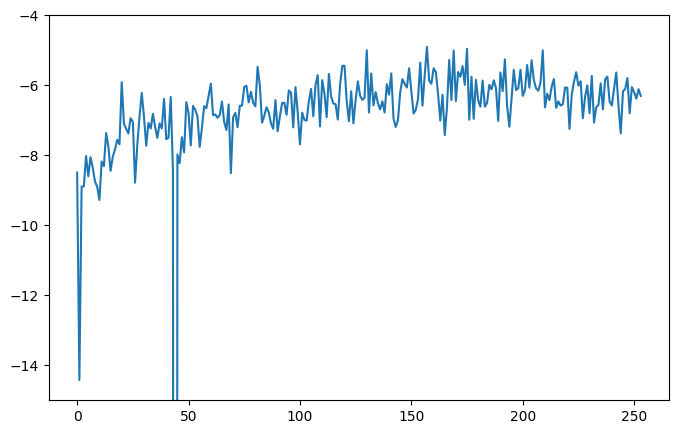

In [66]:
plt.figure(figsize=(8,5))
plt.plot((reward_records))
plt.ylim([-15,-4])

## Run Evaluation

In [67]:
""" 1. Model Loading"""
# Q_origin = torch.load('./Q_origin_random.pt')
# mu_origin = torch.load('./mu_origin_random.pt')
Q_origin = torch.load('./Q_origin_random_2.pt')
mu_origin = torch.load('./mu_origin_random_2.pt')
# Q_origin = torch.load('./Q_origin_random_3.pt')
# mu_origin = torch.load('./mu_origin_random_3.pt')
# Q_origin = torch.load('./Q_origin_random_4.pt')
# mu_origin = torch.load('./mu_origin_random_4.pt')
Q_origin.eval()
mu_origin.eval()
ou_action_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(output_dim), sigma=np.ones(output_dim) * 0.)

""" 2. GENERATE ROAD PROFILE FOR TESTING"""
# road_profile = generate_road(TIME, MAX_BUMP)
road_profile = list(testprofile.get_profile_by_class("C", t_stop, dt)[1][:])

""" 3. LIST FOR STORING TESTING RESULTS"""
xb_time, rl_xb_time = [], []
dxb_time, rl_dxb_time = [], []
xw_time, rl_xw_time = [], []
dxw_time, rl_dxw_time = [], []
d2xb_time, rl_d2xb_time = [], []
rl_cs = []
rl_ks = []

"""************************************
    1. PASSIVE SYSTEM
************************************"""
"""
    Initialize the first state of the quarter car model & RL model
     * state_ODE e R4: [x_body, x_wheel, d/dt(x_body), d/dt(x_wheel)]
"""
# [xb, xw, dxb, dxw] e R4 -> state representation of the quarter car model
s_ode = [road_profile[0], road_profile[0], 0, 0]
print(s_ode)

for t_idx, t in enumerate(TIME):
    """####################################
        I. S{t} COMPUTATION
    ####################################"""
    xb, xw, dxb, dxw = np.array(s_ode)[0:4]
    d2xb = (-cs * (dxb-dxw) - ks * (xb-xw)) / m1

    """ 1.2. Record curves"""
    xb_time.append(xb)
    dxb_time.append(dxb)
    xw_time.append(xw)
    dxw_time.append(dxw)
    d2xb_time.append(d2xb)

    """####################################
        II. S{t+1} TRANSITION
    ####################################"""
    yout = solve_ivp(odefun, [t, t+dt], s_ode, args=(m, cs, kw, ks ), dense_output=True)
    xb = yout.y[0,-1]    #yout.y is the solution of the ODE -> s{t+1}
    xw = yout.y[1,-1]
    dxb = yout.y[2,-1]
    dxw = yout.y[3,-1]

    """####################################
        III. TRANSITION TO NEXT STATE
    ####################################"""
    s_ode_next = [xb, xw, dxb, dxw]
    s_ode = s_ode_next

"""************************************
    2. RL-BASED CONTROL
************************************"""
# [xb, xw, dxb, dxw] e R4 -> state representation of the quarter car model
s_ode = [road_profile[0], road_profile[0], 0, 0]
s_ode_prev = s_ode
print(s_ode)
total_reward = 0

for t_idx, t in enumerate(TIME):
    """####################################
        I. S{t} & A{t} COMPUTATION
    ####################################"""
    """ 1.1. Get current state s{t} from ODE """
    xb, xw, dxb, dxw = np.array(s_ode)[0:4]
    dxr = (road_profile[t_idx] - road_profile[t_idx-1]) / dt
    xb_prev, xw_prev, dxb_prev, dxw_prev = np.array(s_ode_prev)[0:4]
    dxr_prev = (road_profile[max(t_idx-1, 0)] - road_profile[max(t_idx-2, 0)]) / dt
    # s_rl = [xb, xw, dxb, dxw, dxr] # rescale
    # s_rl = [dxb, dxw, dxr] # rescale
    s_rl = [dxb, dxw, dxr, dxb_prev, dxw_prev, dxr_prev]
    """ 1.2. Take action a{t} from RL's s{t}"""
    a = pick_sample(s_rl, ou_action_noise)
    a_cs, a_ks  = a
    """ 1.3. Compute d2/dt (x_body)"""
    d2xb = (-get_cs(a_cs) * (dxb-dxw) - get_ks(a_ks) * (xb-xw)) / m1

    """ 1.4. Record curves"""
    rl_xb_time.append(xb)
    rl_dxb_time.append(dxb)
    rl_xw_time.append(xw)
    rl_dxw_time.append(dxw)
    rl_d2xb_time.append(d2xb)
    rl_cs.append(get_cs(a_cs))
    rl_ks.append(get_ks(a_ks))


    """####################################
            II. S{t+1} TRANSITION (from S{t} & A{t})
        ####################################"""
    del xb, xw, dxb, dxw # delete these variables for debugging purpose
    """ 2a. Solve ODE for s{t+1} """
    yout = solve_ivp(odefun, [t, t+dt], s_ode, args=(m, get_cs(a_cs), kw, get_ks(a_ks) ), dense_output=True)
    # yout.y is the solution of the ODE -> s{t+1}
    xb_next, xw_next, dxb_next, dxw_next = yout.y[:,-1]
    if t_idx < len(TIME)-1:
        dxr_next = (road_profile[t_idx+1] - road_profile[t_idx]) / dt
    """ 2.2. Record next states"""
    s_ode_next = [xb_next, xw_next, dxb_next, dxw_next]
    # s_rl_next = [xb, xw, dxb, dxw, dxr]
    s_rl_next = [dxb_next, dxw_next, dxr_next]
    """ 2.3. Check final state"""
    done = False if (t_idx < len(TIME)-1) else True

    # """ compute C_skyhook """
    # if abs(dxb) > 0.01:
    #     c_sky = cs * (dxb-dxw) / dxb
    # else:
    #     c_sky = cs
    # """ derive d2/dt(x_body) """
    # d2xb = (-ks*(xb-xw) - c_sky*dxb) / m1

    """####################################
        III. REWARDS
    ####################################"""
    # r = 0.9*(-1000*(abs(xb)**3)) + 0.1*(-0.01*(abs(d2xb)**2))
    # r = -0.9*abs(xb) - 0.1*abs(dxb)
    r = -0.1*abs(dxb_next)
    total_reward += r

    """####################################
        IV. STATE TRANSITION
    ####################################"""
    s_ode_prev = s_ode
    s_ode = s_ode_next

print(f'Total Reward = {total_reward}')
print("\nDone")
print('-------------------------')
print(rl_dxw_time)

[0.013099425867451076, 0.013099425867451076, 0, 0]
[0.013099425867451076, 0.013099425867451076, 0, 0]
Total Reward = -1.6754104225452842

Done
-------------------------
[0.0, -0.004579391645987231, -0.013548305031184852, -0.02041917219040951, -0.021304606082311783, -0.01630287543266426, -0.0023495038348437143, 0.024509721364169883, 0.056859666836240996, 0.08230975998920098, 0.11180366370591134, 0.1309761305230009, 0.11296626247651281, 0.06707646279054327, 0.01051333051001626, -0.03231582994024074, -0.05162515125258339, -0.05610586036448503, -0.04324026464596725, -0.010949278222345746, 0.019222965876049415, 0.038557177848513986, 0.058875451729023136, 0.08482221223212133, 0.1071052838727789, 0.10989417508495905, 0.0839350095475242, 0.05034368668912957, 0.016328122252184836, -0.013766988819013172, -0.006629495744528971, 0.016704112633353013, 0.028196235869827432, 0.03418889052548563, 0.03454366384245081, 0.023743027351374978, -0.0014097991734557842, -0.04205692777644979, -0.08358692641773

In [68]:
import pandas as pd

dict = {'rl_xw_t': rl_xw_time}
df = pd.DataFrame(dict)
df.to_csv('RL_xw_t.csv', index=False)

1500
1206.817477941513 10582.479000091553


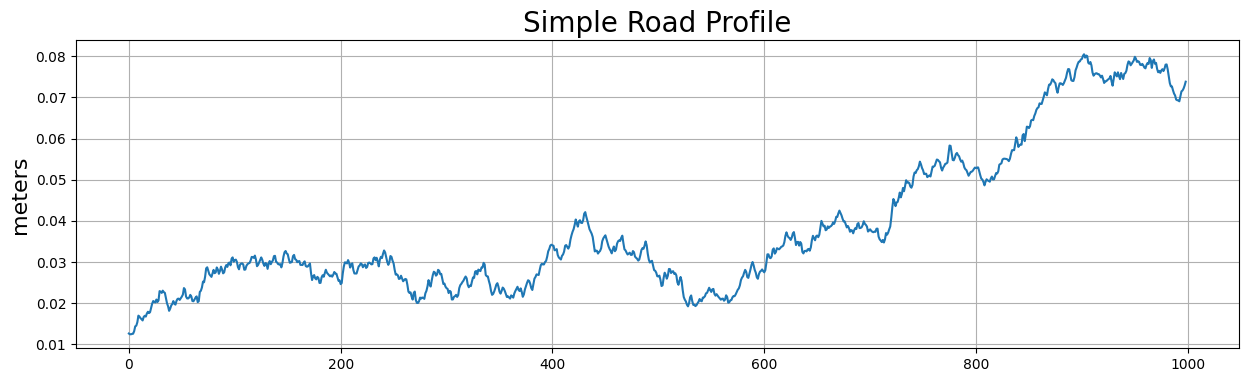

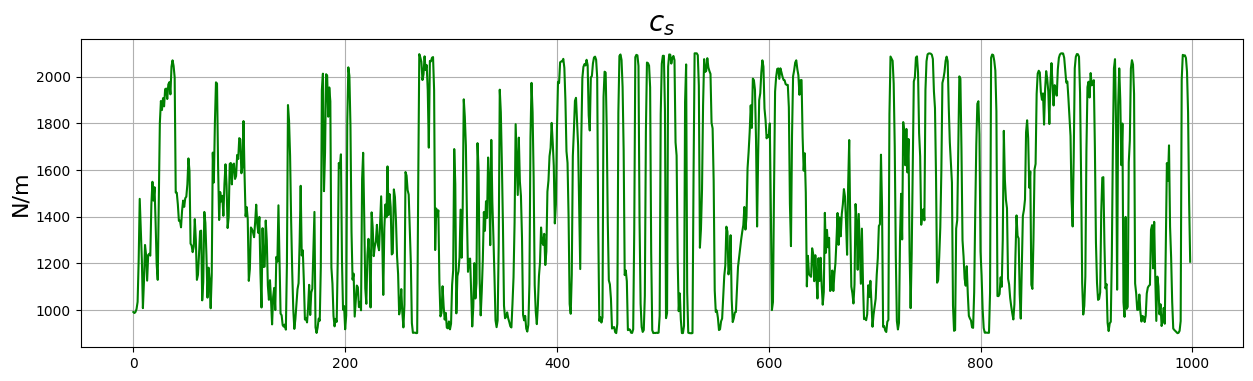

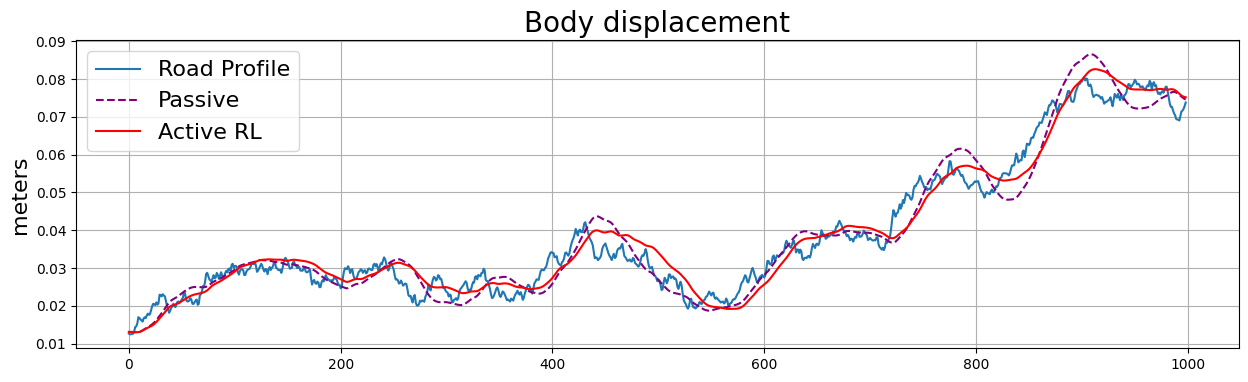

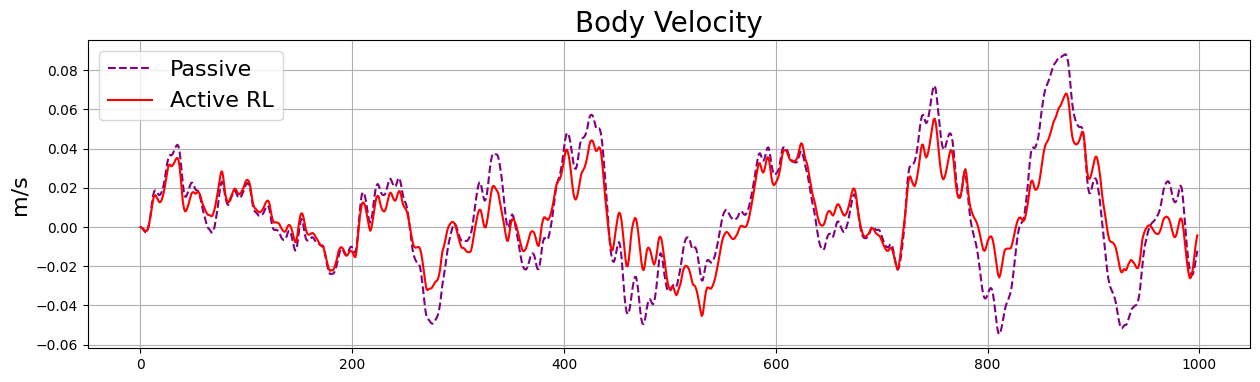

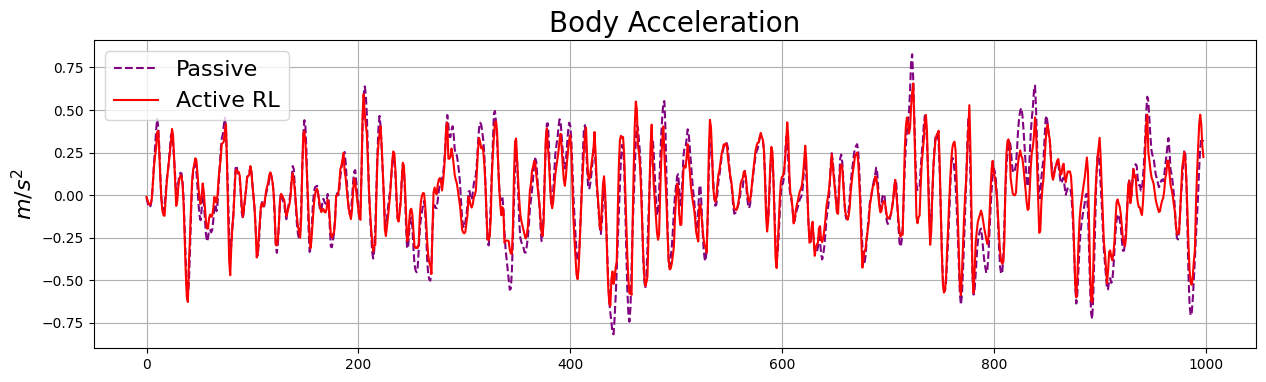

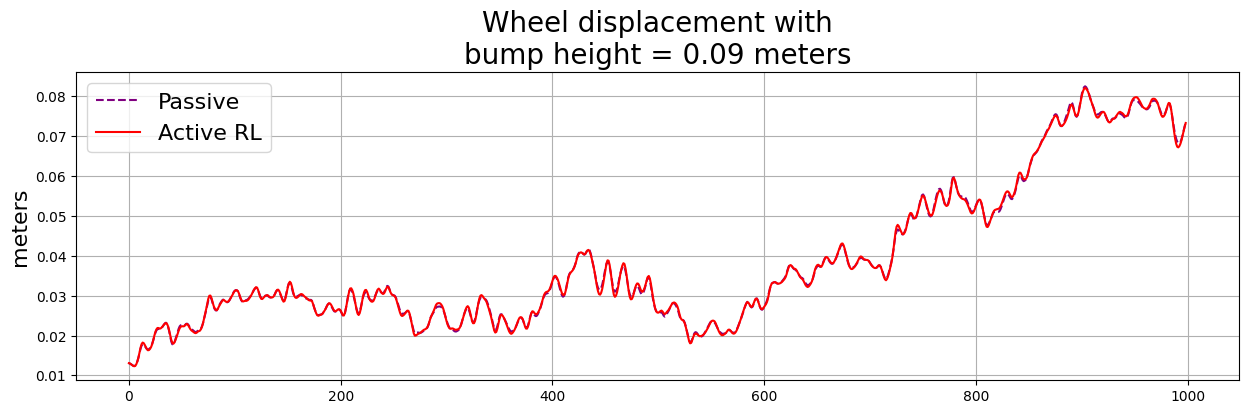

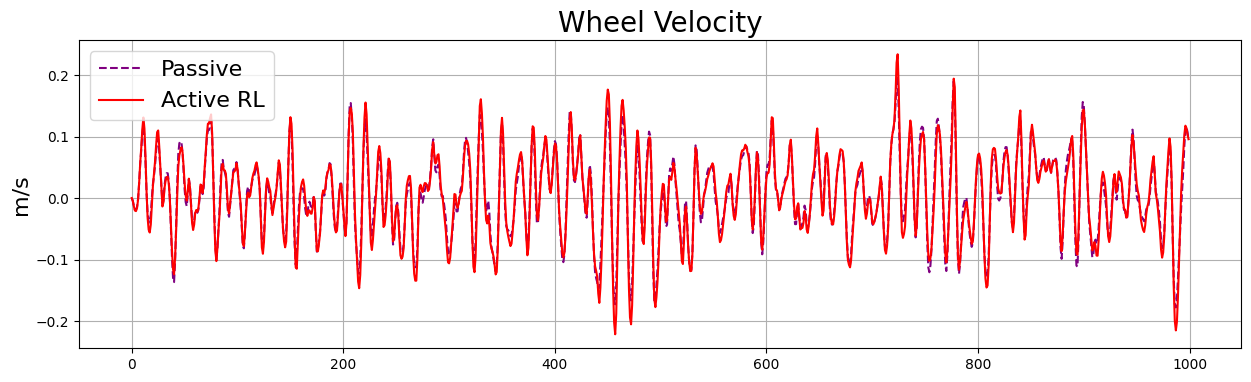

In [69]:
print(cs)
a_cs, a_ks  = pick_sample(s_rl, ou_action_noise)
print(get_cs(a_cs), get_ks(a_ks))

""" Visualization"""
# fig, ax = plt.subplots(ncols=3, figsize=(60,5))
plt.figure(figsize=(15,4))
plt.title(f'Simple Road Profile', fontsize=20)
plt.plot(road_profile[1:len(xb_time)])
plt.ylabel('meters', fontsize=16)
# plt.ylim([-0.1, 0.2])
plt.grid()

plt.figure(figsize=(15,4))
plt.title(f'$c_s$', fontsize=20)
# plt.plot(cs, '--', color='darkblue')
plt.plot(rl_cs[1:], color='green')
plt.ylabel('N/m', fontsize=16)
# ax[2].set_ylim([-1*MAX_BUMP, 1.5*MAX_BUMP])
plt.grid('--')

# plt.figure(figsize=(15,4))
# plt.title(f'$k_s$', fontsize=20)
# # plt.plot(cs, '--', color='darkblue')
# plt.plot(rl_ks[1:], color='green')
# plt.ylabel('N/m', fontsize=16)
# # ax[2].set_ylim([-1*MAX_BUMP, 1.5*MAX_BUMP])
# plt.grid('--')

plt.figure(figsize=(15,4))
plt.title(f'Body displacement', fontsize=20)
plt.plot(road_profile[1:len(xb_time)], label='Road Profile')
plt.plot(xb_time[1:], '--', color='purple', label='Passive')
plt.plot(rl_xb_time[1:], color='red', label='Active RL')
plt.ylabel('meters', fontsize=16)
# plt.ylim([-2*MAX_BUMP, 2*MAX_BUMP])
plt.grid('--')
plt.legend(fontsize=16)

plt.figure(figsize=(15,4))
plt.title(f'Body Velocity', fontsize=20)
plt.plot(dxb_time[1:], '--', color='purple', label='Passive')
plt.plot(rl_dxb_time[1:], color='red', label='Active RL')
plt.ylabel('m/s', fontsize=16)
# ax[2].set_ylim([-1*MAX_BUMP, 1.5*MAX_BUMP])
plt.grid('--')
plt.legend(fontsize=16)

plt.figure(figsize=(15,4))
plt.title(f'Body Acceleration', fontsize=20)
plt.plot(d2xb_time[1:], '--', color='purple', label='Passive')
plt.plot(rl_d2xb_time[1:], color='red', label='Active RL')
plt.ylabel('$m/s^2$', fontsize=16)
# ax[2].set_ylim([-1*MAX_BUMP, 1.5*MAX_BUMP])
plt.grid('--')
plt.legend(fontsize=16)

plt.figure(figsize=(15,4))
plt.title(f'Wheel displacement with\nbump height = {MAX_BUMP} meters', fontsize=20)
# plt.plot(road_profile[1:(len(xb_time))], label='Road Profile')
plt.plot(xw_time[1:], '--', color='purple', label='Passive')
plt.plot(rl_xw_time[1:], color='red', label='Active RL')
plt.ylabel('meters', fontsize=16)
# plt.ylim([-2*MAX_BUMP, 2*MAX_BUMP])
plt.grid('--')
plt.legend(fontsize=16)


plt.figure(figsize=(15,4))
plt.title(f'Wheel Velocity', fontsize=20)
plt.plot(dxw_time[:10000], '--', color='purple', label='Passive')
plt.plot(rl_dxw_time[:10000], color='red', label='Active RL')
plt.ylabel('m/s', fontsize=16)
# ax[2].set_ylim([-1*MAX_BUMP, 1.5*MAX_BUMP])
plt.grid('--')
plt.legend(fontsize=16)